# LMC Multi-scale non-Gaussian Segmentation
## Small region demo
Jean-François Robitaille ([jean-francois.robitaille@univ-grenoble-alpes.fr](mailto:jean-francois.robitaille@univ-grenoble-alpes.fr))

[Pywavan](https://github.com/jfrob27/pywavan) revolves mainly around one function which is dedicated to the wavelet power spectrum analysis of a map and its **Multi-scale non-Gaussian Segmentation (MnGSeg)**. It also contains functions to perform the **classical Fourier power spectrum analysis**, generate **fractal simulations** and do basic data manipulation, such as **cutting fits maps**, **beam convolution**.

### Dependencies

Plots and matrices

In [ ]:
!pip install matplotlib numpy

Dowload and manage fits data

In [ ]:
!pip install aplpy astropy

*Pywavan* package

In [ ]:
!pip install git+https://github.com/jfrob27/pywavan.git

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Load packages

In [4]:
from pywavan import fbm2d, powspec, imsmooth, fan_trans, apodize, padding, gauss_beam, nb_scale
import aplpy
from astropy.io import fits

In [5]:
plt.rc('font', **{'family': 'serif', 'size': 32})
plt.rc('lines', linewidth = 2.5)
plt.rc('text', usetex=True)

In [39]:
#Read map
HDU = fits.open('/Users/robitaij/postdoc/CEA_simu/heritage_lmc_conv_s500_bkgsub_7mar13/lmc_both_spire_500_cutc.fits')
im = HDU[0].data
header = HDU[0].header

#Replace NaNs with zeros
im[im != im] = 0.

INFO: Auto-setting vmin to -1.115e+00 [aplpy.core]


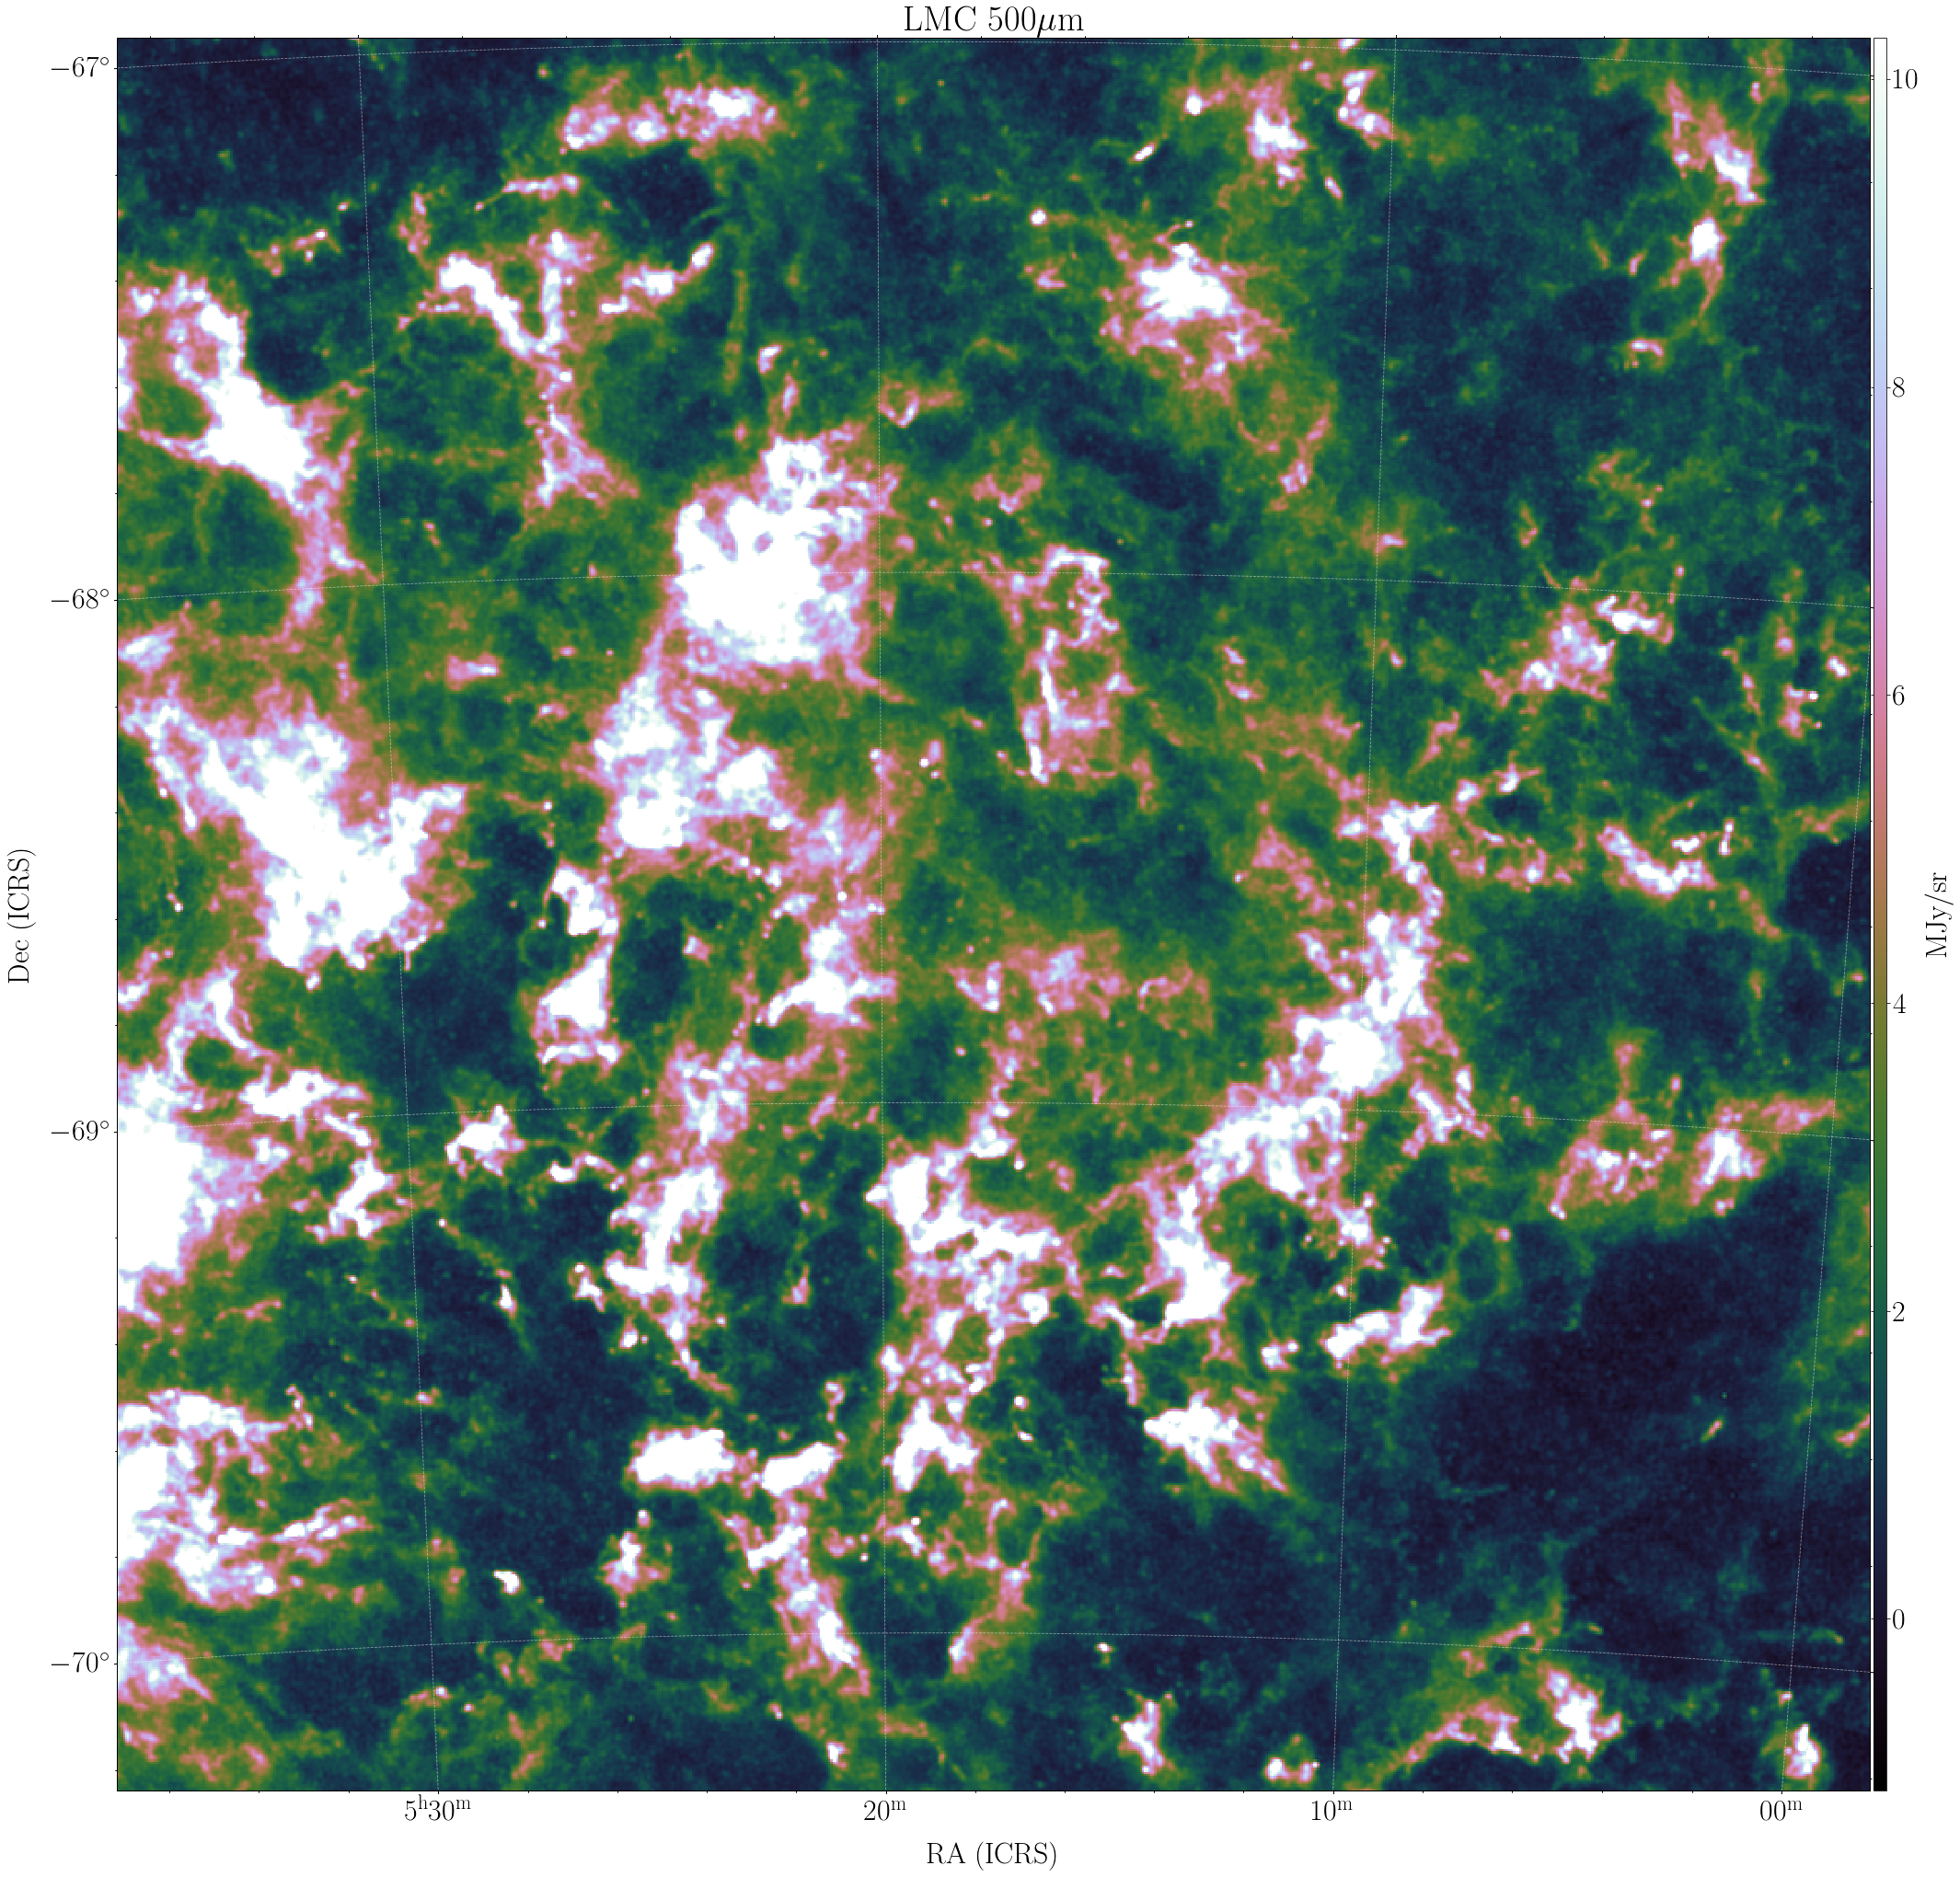

In [40]:
fig_all = plt.figure(1, figsize=(30,30))

fig = aplpy.FITSFigure(fits.PrimaryHDU(im,header), figure=fig_all)
fig.show_colorscale(cmap='cubehelix',vmax=10.27)
fig.add_colorbar()
fig.colorbar.set_axis_label_text(header['ZUNITS'])
fig.set_title(r'LMC 500$\mu$m')
fig.add_grid()
fig.grid.set_color('white')
fig.grid.set_alpha(0.5)
fig.grid.set_linestyle('--')

plt.tight_layout()

## Fourier Power spectrum analysis

In [17]:
#Resolution in arcmin
reso = header['CD2_2'] * 60.

imzm = im - np.mean(im)

#Apodization
tapper = apodize(im.shape[0],im.shape[1],0.98)
imt = imzm *tapper
imr = padding(imt,1024,1024)

#Fourier power spectrum
tab_k, spec_k = powspec(imr, reso=reso)

#Beam Power spectrum
FWHM = 36. / (60.*reso)  #Beam size at 500 micron
beam = gauss_beam(FWHM,1024,1024,FWHM=True)
tab_k, spec_beam = powspec(beam, reso=reso)
spec_beamn = spec_beam/spec_beam[0]  #Spectrum normalisation

#Noise
Noise = spec_k[-1]

Power law
-1.9646647931718362


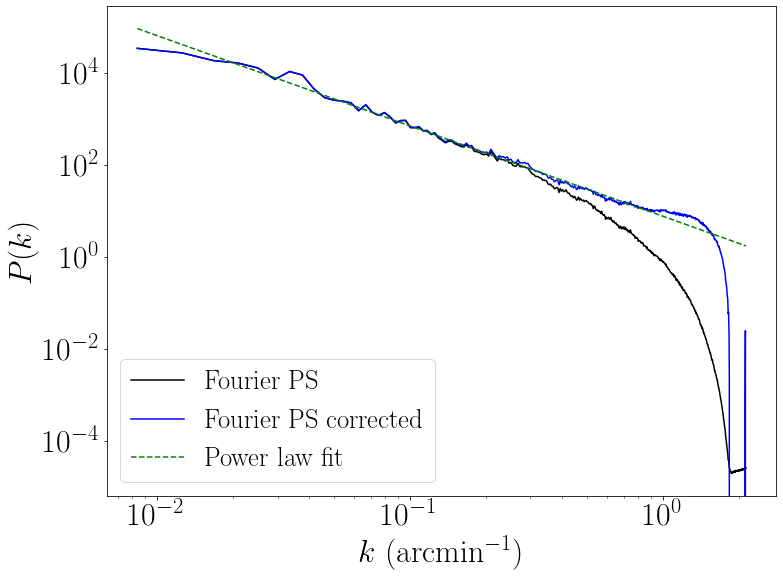

In [18]:
#Power law fit
limit = np.where((tab_k > tab_k[0]) & (tab_k < 0.5))
coef,cov = np.polyfit(np.log(tab_k[limit]),np.log((spec_k[limit]- Noise)/spec_beamn[limit]),deg=1,cov=True)
yfit = np.exp(coef[1])*tab_k**coef[0]

print('Power law')
print(coef[0])

plt.figure(figsize=(12,9))
plt.plot(tab_k[1:], spec_k[1:], color='black',label='Fourier PS', linewidth=1.5)
plt.plot(tab_k[1:], (spec_k[1:]- Noise)/spec_beamn[1:], color='blue',label='Fourier PS corrected', linewidth=1.5)
plt.plot(tab_k[1:], yfit[1:],'--', color='green',label='Power law fit', linewidth=1.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$k$ (arcmin$^{-1}$)")
plt.ylabel(r"$P(k)$")
plt.legend(fontsize='small', loc='lower left')

## Wavelet transform and segmentation

In [36]:
#Set a list of q
q=[]
q=[2.9]*nb_scale(imr.shape)

#Wavelet power spectrum
wt, S11a, wav_k, S1a, q = fan_trans(im, reso=reso, q=q, qdyn=True, skewl=0.4, apodize=0.98, arrdim=np.array([1024,1024]))

  0%|          | 0/24 [00:00<?, ?it/s]

1024 1024


100%|██████████| 24/24 [11:15<00:00, 28.14s/it]


In [27]:
Bwt, BS11a, Bwav_k, BS1a, Bq = fan_trans(beam, reso=reso, q=0, qdyn=False)
del Bwt,BS11a,Bq
#Normalisation
BS1an = BS1a / BS1a[3]
BS1an[0:3] = 1.

In [48]:
M = nb_scale(imr.shape)

#Map reconstruction of the Gaussian (fractal) and coherent (non-Gaussian) part
coherent = np.sum(wt[M:2*M,:,:],axis=0).real + np.mean(im)
Gaussian = np.sum(wt[2*M:3*M,:,:],axis=0).real + np.mean(im)

INFO: Auto-setting vmin to -9.493e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.056e+01 [aplpy.core]


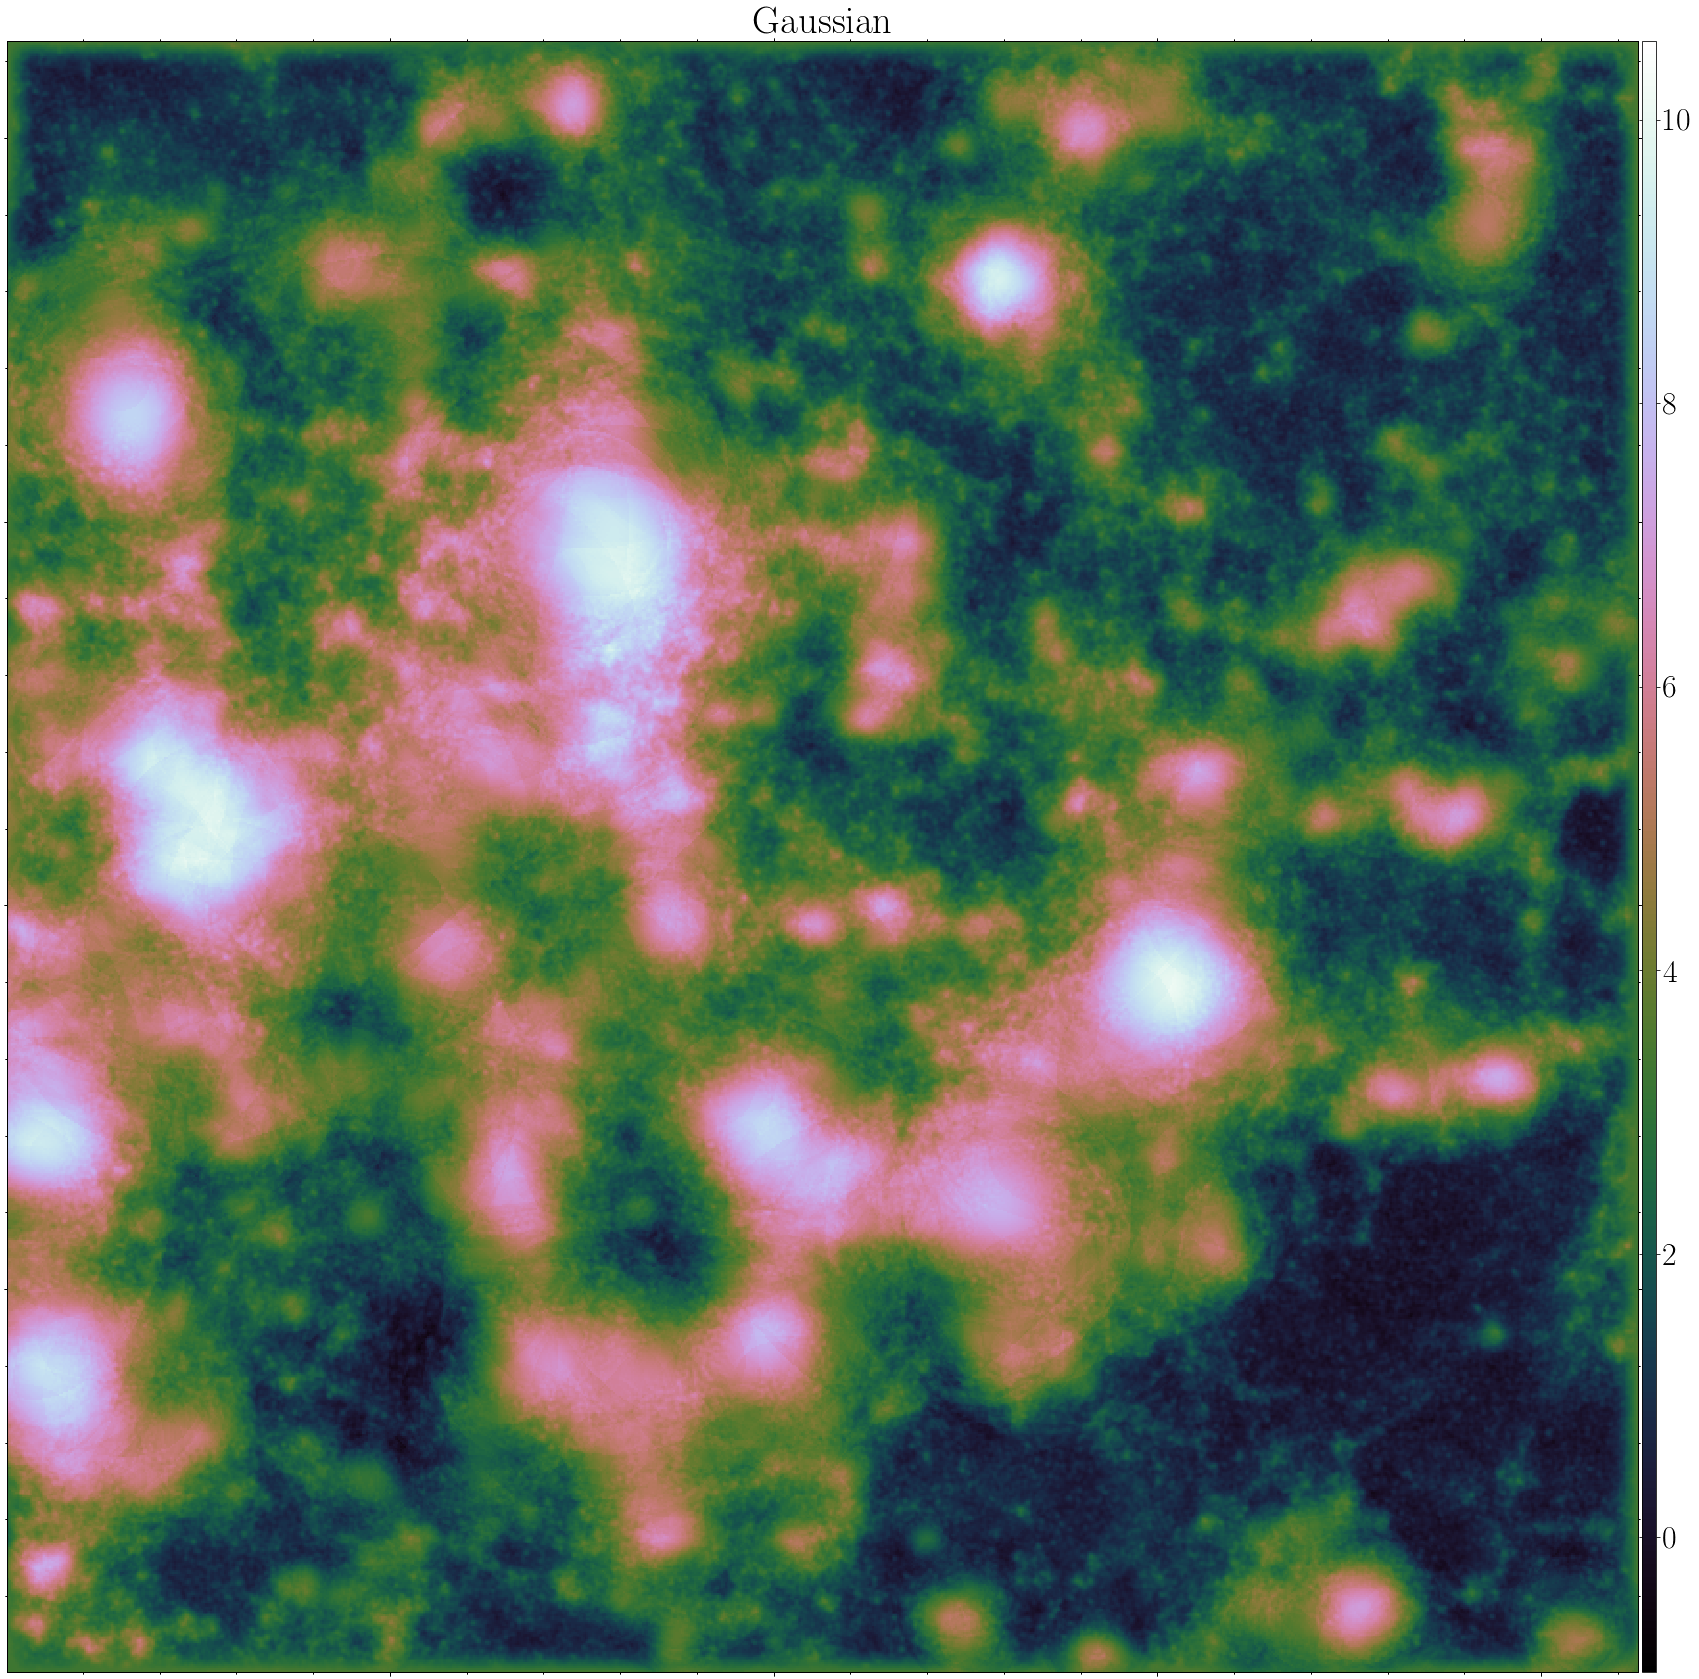

In [49]:
fig_all = plt.figure(1, figsize=(30,30))
fig = aplpy.FITSFigure(fits.PrimaryHDU(Gaussian), figure=fig_all)
fig.show_colorscale(cmap='cubehelix')
fig.add_colorbar()
fig.axis_labels.hide()
fig.tick_labels.hide()
fig.set_title('Gaussian')

INFO: Auto-setting vmin to -3.474e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.326e+01 [aplpy.core]


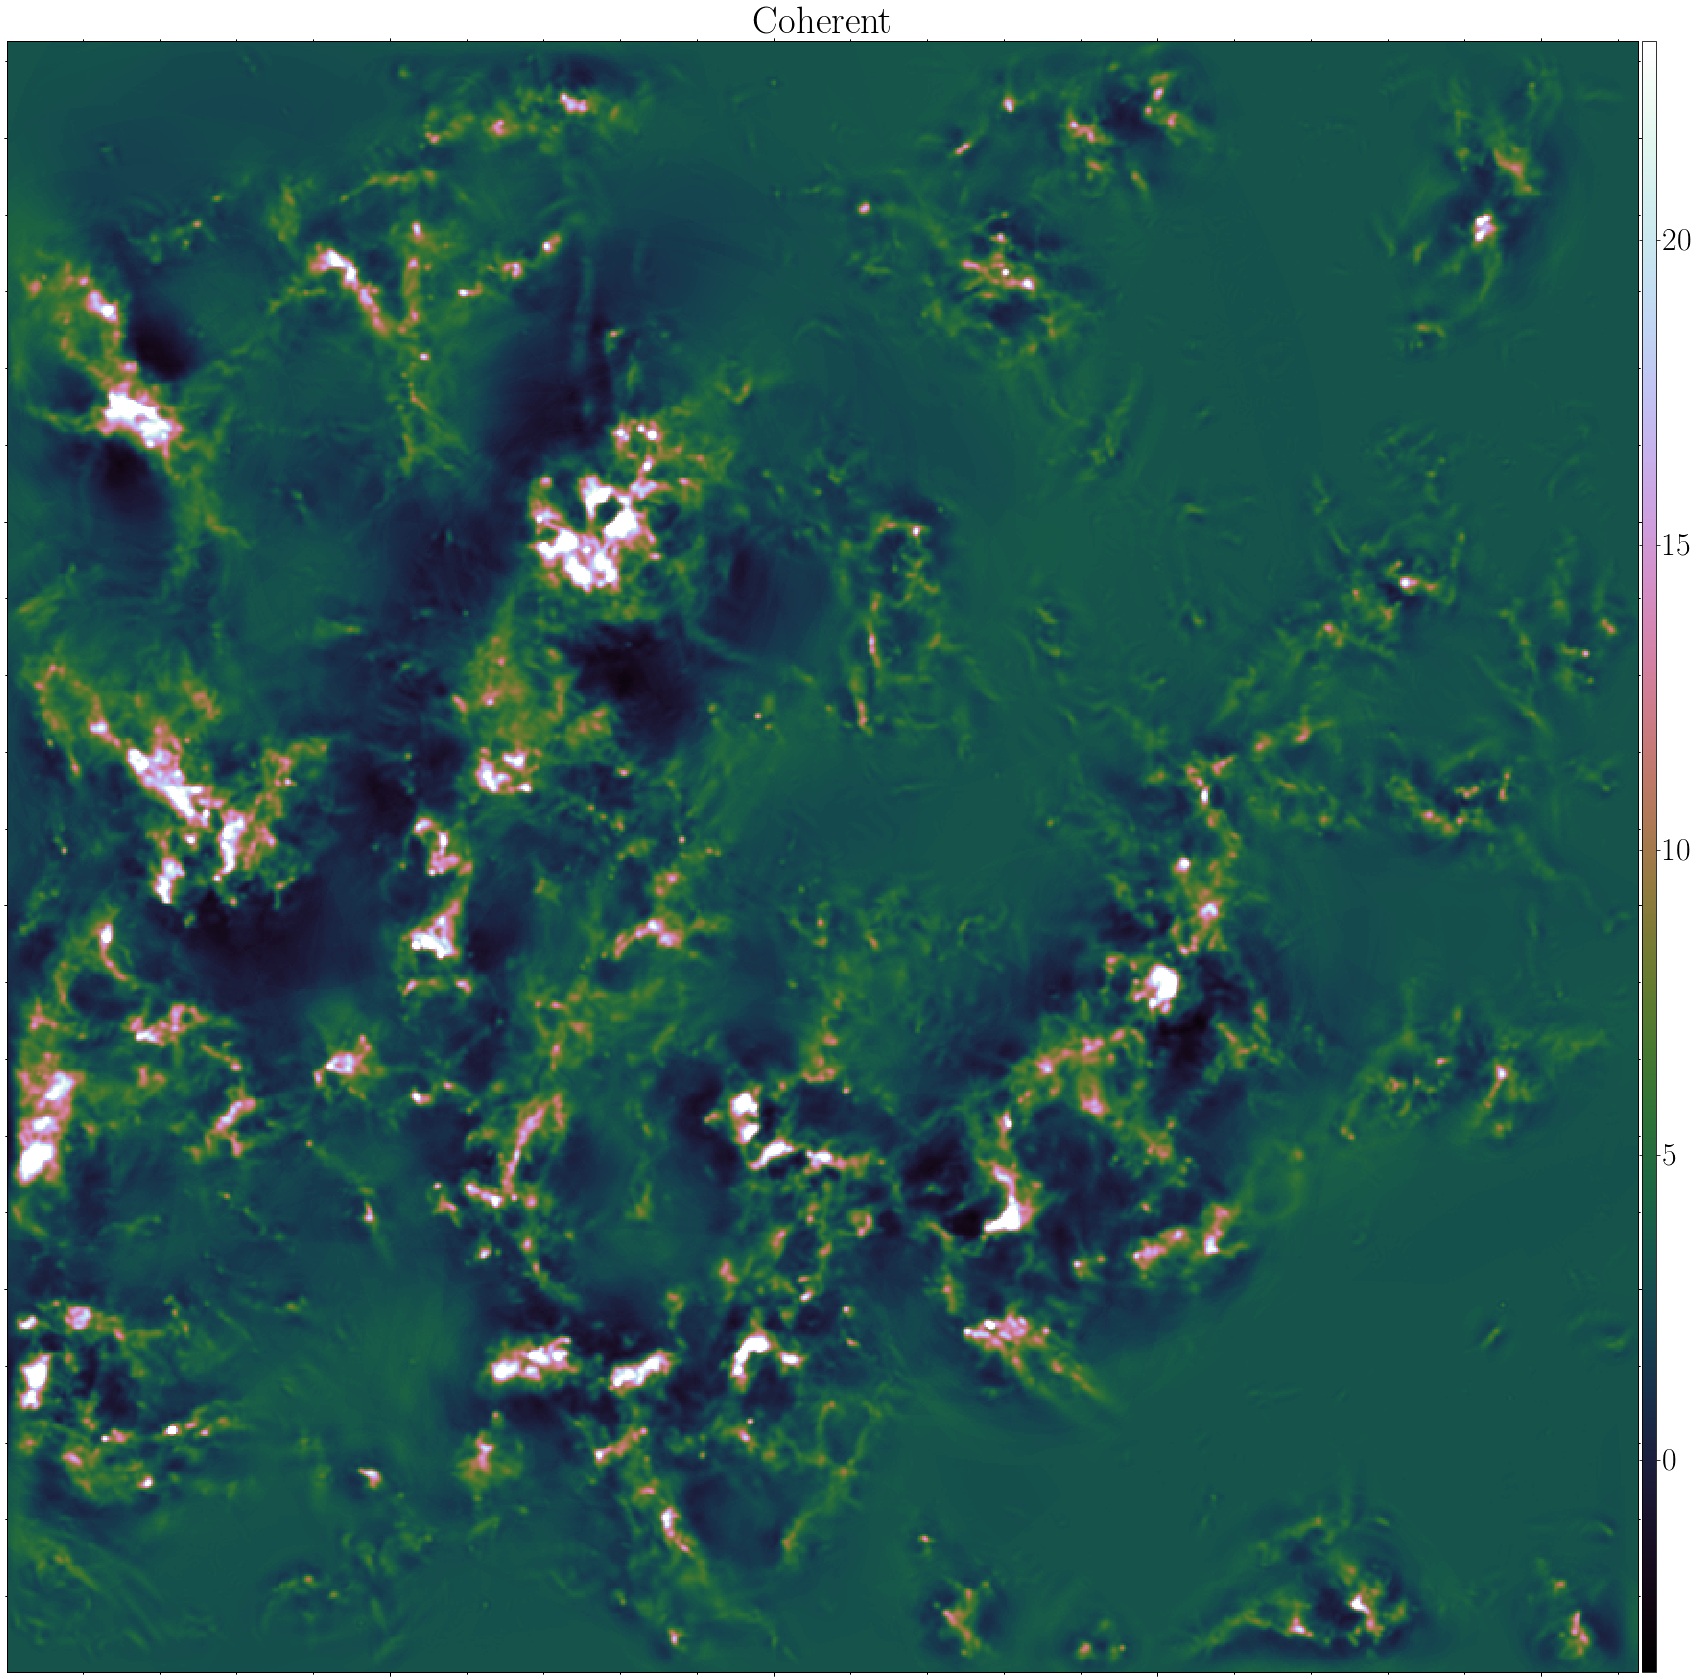

In [50]:
fig_all = plt.figure(1, figsize=(30,30))
fig = aplpy.FITSFigure(fits.PrimaryHDU(coherent), figure=fig_all)
fig.show_colorscale(cmap='cubehelix')
fig.add_colorbar()
fig.axis_labels.hide()
fig.tick_labels.hide()
fig.set_title('Coherent')

### Wavelet power spectra

The wavelet transforms are designed to reproduce the Fourier power spectrum when the coefficeints are averaged:

$$P^W(l,\vec{x})=\frac{\delta \theta}{N_{\theta}} \sum_{j=0}^{N_{\theta}-1}  |\tilde{f}(l,\vec{x},\theta_j)|^2$$

$$P^W(l)=\frac{1}{N_{\vec{x}}} \sum_{\vec{x}} P^W(l,\vec{x})$$

where $\tilde{f}(l,\vec{x},\theta)$ are the Morlet wavelet coefficients for map $f(\vec{x})$ and $N_{\theta}=\Delta \theta/\delta \theta$ is the number of directions $\theta$ needed to sample the Fourier space over the range $\Delta \theta$ ([Robitaille et al. 2019](https://ui.adsabs.harvard.edu/abs/2019arXiv190511492R/abstract)).

The Fourier power spectrum is not sensitive to non-Gaussianities. However, the wavelet segmentation allows us to calculate their enegy distribution through the wavelet power spectrum of non-Gaussian coefficients only (**Coherent PS**). In the litterature and according to the fractal formalism ([Frisch 1995](http://adsabs.harvard.edu/abs/1995turb.book.....F)), the Gaussian field, which respect a power law scaling, is mono-fractal by nature, and thus fully described by its single power law. The non-Gaussian part has multi-fractal properties ([Robitaille et al. 2020](https://arxiv.org/abs/2007.08206)) and, consequently, cannot be fully described by its power spectrum. Nevertheless, the coherent power spectrum can give us an estimation of the non-Gaussian energy distribution as a function of scales.

Gaussian Power law
-3.545953983715366 

Coherent Power law
-1.755820106972145


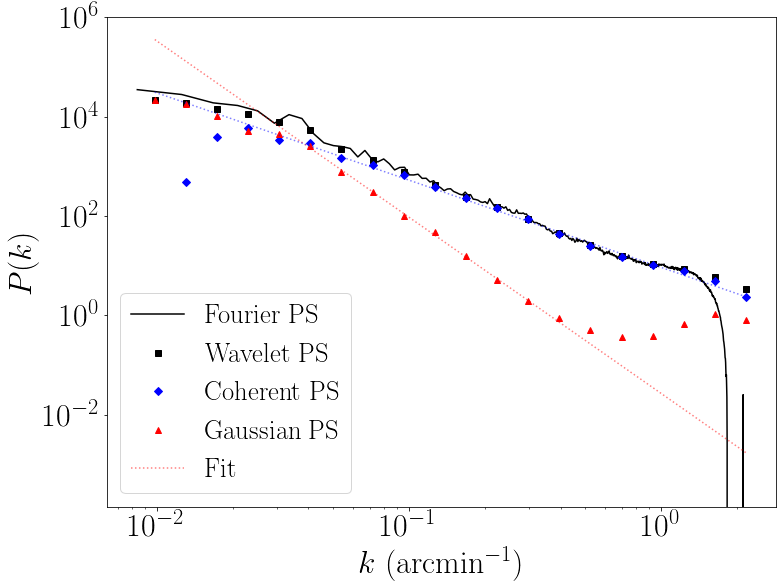

In [42]:
# Gaussian Power law fit
coefw,cov = np.polyfit(np.log(wav_k[8:16]),np.log((S1a[2,8:16]- Noise)/BS1an[8:16]),deg=1,cov=True)
yfitw = np.exp(coefw[1])*wav_k**coefw[0]

print('Gaussian Power law')
print(coefw[0],'\n')

# Coherent Power law fit 1/3
coefcw,cov = np.polyfit(np.log(wav_k[6:20]),np.log((S1a[1,6:20]- Noise)/BS1an[6:20]),deg=1,cov=True)
yfitcw = np.exp(coefcw[1])*wav_k**coefcw[0]

print('Coherent Power law')
print(coefcw[0])

plt.figure(figsize=(12,9))
plt.plot(tab_k[1:], (spec_k[1:]- Noise)/spec_beamn[1:], color='black',label='Fourier PS', linewidth=1.5)
plt.plot(wav_k[3:-1], (S1a[0,3:-1]- Noise)/BS1an[3:-1],'s',color='black', label='Wavelet PS')
plt.plot(wav_k[3:-1], (S1a[1,3:-1]- Noise)/BS1an[3:-1],'D',color='blue', label='Coherent PS')
plt.plot(wav_k[3:-1], (S1a[2,3:-1]- Noise)/BS1an[3:-1],'^',color='red', label='Gaussian PS')
plt.plot(wav_k[3:-1], yfitw[3:-1],':', color='red', linewidth=1.5, alpha=0.5,label='Fit')
plt.plot(wav_k[3:-1], yfitcw[3:-1],':', color='blue', linewidth=1.5, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$k$ (arcmin$^{-1}$)")
plt.ylabel(r"$P(k)$")
plt.legend(fontsize="small")